In [4]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

In [9]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

data_transform = transforms.ToTensor()
train_data = FashionMNIST(root='./FashionMNIST_data', train=True, download=True, transform=data_transform)
test_data = FashionMNIST(root='./FashionMNIST_data', train=False, download=True, transform=data_transform)

print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

100.0%
Extracting ./FashionMNIST_data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST_data\FashionMNIST\raw
100.6%
Extracting ./FashionMNIST_data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST_data\FashionMNIST\raw
100.0%
Extracting ./FashionMNIST_data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST_data\FashionMNIST\raw
119.3%
Extracting ./FashionMNIST_data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST_data\FashionMNIST\raw
Processing...
f:\My Career data\Computer Vision Notes\Practicals\venv2\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

In [10]:
batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<ipython-input-13-2e4ed1b93c3b>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])


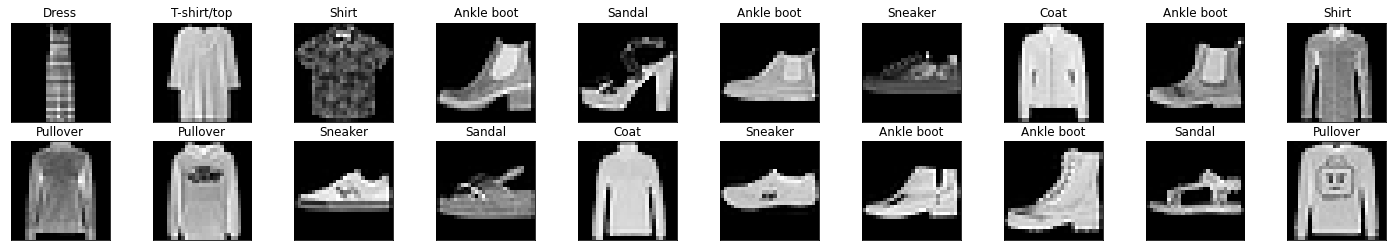

In [13]:
images, labels = next(iter(train_loader))
images = images.numpy()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [18]:
from torch import nn
from torch.nn import functional as F
from torch import optim

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1,10,3)
        self.pool = nn.MaxPool2d(2,2)  # maxpool layer pool with kernel_size=2, stride=2
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10,20,3)
        self.fc1 = nn.Linear(20*5*5, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten the inputs into a vector
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        return x 
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


In [58]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [59]:
# Calculate accuracy before training
correct = 0
total = 0
'''with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()'''

for images, labels in test_loader:
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
accuracy = 100 * correct / total
print('Accuracy before training: ', accuracy)

Accuracy before training:  tensor(86.2900)


In [60]:
def train(n_epochs):
    loss_over_time = [] # to track the loss as the network trains
    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [61]:
n_epochs = 30
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 0.32771830473840236
Epoch: 1, Batch: 2000, Avg. Loss: 0.3193746933229268
Epoch: 1, Batch: 3000, Avg. Loss: 0.3302361276745796
Epoch: 2, Batch: 1000, Avg. Loss: 0.3222865683585405
Epoch: 2, Batch: 2000, Avg. Loss: 0.3211350060813129
Epoch: 2, Batch: 3000, Avg. Loss: 0.3275626890696585
Epoch: 3, Batch: 1000, Avg. Loss: 0.3253274185247719
Epoch: 3, Batch: 2000, Avg. Loss: 0.321013638317585
Epoch: 3, Batch: 3000, Avg. Loss: 0.32185988234728574
Epoch: 4, Batch: 1000, Avg. Loss: 0.3210072943009436
Epoch: 4, Batch: 2000, Avg. Loss: 0.32341399099584667
Epoch: 4, Batch: 3000, Avg. Loss: 0.31952978121489284
Epoch: 5, Batch: 1000, Avg. Loss: 0.3252280608639121
Epoch: 5, Batch: 2000, Avg. Loss: 0.3204815225992352
Epoch: 5, Batch: 3000, Avg. Loss: 0.3166241669263691
Epoch: 6, Batch: 1000, Avg. Loss: 0.31979755495861173
Epoch: 6, Batch: 2000, Avg. Loss: 0.3225448336787522
Epoch: 6, Batch: 3000, Avg. Loss: 0.3166955621168017
Epoch: 7, Batch: 1000, Avg. Loss: 0.320386

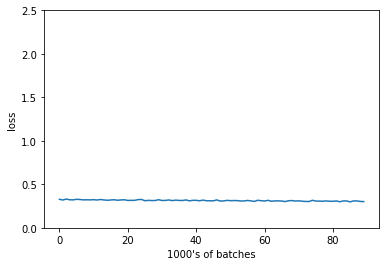

In [62]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

In [63]:
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
net.eval()
for batch_i, data in enumerate(test_loader):
    inputs, labels = data
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.335742

Test Accuracy of T-shirt/top: 83% (834/1000)
Test Accuracy of Trouser: 97% (970/1000)
Test Accuracy of Pullover: 79% (799/1000)
Test Accuracy of Dress: 90% (902/1000)
Test Accuracy of  Coat: 86% (860/1000)
Test Accuracy of Sandal: 95% (959/1000)
Test Accuracy of Shirt: 59% (591/1000)
Test Accuracy of Sneaker: 96% (962/1000)
Test Accuracy of   Bag: 96% (967/1000)
Test Accuracy of Ankle boot: 95% (952/1000)

Test Accuracy (Overall): 87% (8796/10000)


<ipython-input-64-2abde717b697>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])


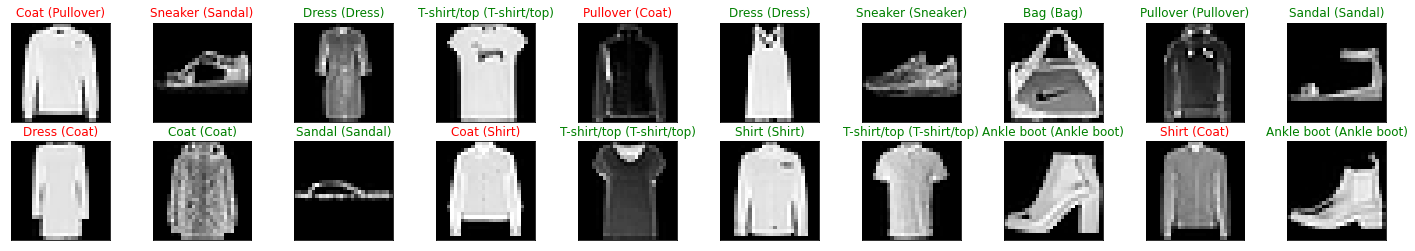

In [64]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [72]:
# Saving the model
model_dir = "../CNN layers and feature visualization/FashionMNIST_data/saved_models/"
model_name = 'fashion_net_simple.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)